In [1]:
# imports and global conf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



sns.set(rc={"figure.dpi":72, 'savefig.dpi':200})
sns.set_theme(font_scale=1.25)

# from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('retina')

In [2]:
# Read dataset (df) & merge regions (Group, Region)
df = pd.read_csv('C:/Users/reyni/Fev23_BDS_meteo/data/weatherAUS.csv', parse_dates=['Date'])
st = pd.read_csv('C:/Users/reyni/Fev23_BDS_meteo/data/locations-regions.csv')
df = df.merge(st[['Location', 'Region', 'Group']], on='Location')
del st
df = df.dropna()

In [3]:
# Geodata load & pre-processing (aprox. ~35 sec)



import geopandas as gpd
from shapely.geometry import Point

# CRS : Coordinate Refernce System
# GPS               EPSG:4326
# Shapefile         EPSG:4283
# Web Mercator      EPSG:3857
# 'flat'            3035

# Australia shapes
ozshape = gpd.read_file("C:/Users/reyni/Fev23_BDS_meteo/data/geo/STE_2021_AUST_SHP_GDA94/STE_2021_AUST_GDA94.shp")
ozshape.to_crs(epsg=4326, inplace=True)

# Regions names ?
# regions = ozshape[ozshape.geometry.notnull()].copy()
# regions['geometry'] = regions.geometry.to_crs(epsg=3035).centroid.to_crs(epsg=4326)

# Locations
locations = gpd.read_file('C:/Users/reyni/Fev23_BDS_meteo/data/locations-regions.csv')
locations['geometry'] = gpd.GeoSeries([Point((l.Lon, l.Lat)) for i, l in locations.iterrows()], crs=4326)

# Weather stations
# Can't fill Na and filter data directly in GeoPandas df, we must do it from a pandas df
stations = pd.read_csv('C:/Users/reyni/Fev23_BDS_meteo/data/weather-stations.csv')
stations.fillna({"End": 2023}, inplace=True)
stations = stations[stations['End'] > 2007][['Site name', 'Lat', 'Lon']].reset_index()
stations = gpd.GeoDataFrame(stations)
stations['geometry'] = gpd.GeoSeries([Point((l.Lon, l.Lat)) for i, l in stations.iterrows()], crs=4326)
stations = stations.sjoin(ozshape)

# Climate
climate = gpd.read_file('C:/Users/reyni/Fev23_BDS_meteo/data/geo/other_climate_2007_koppen_geiger/other_climate_2007_koppen_geiger.shp')
climate.to_crs(epsg=4326, inplace=True)
climate = climate.sjoin(ozshape).drop_duplicates(subset='identity')
tmp = pd.read_csv("C:/Users/reyni/Fev23_BDS_meteo/data/koppen-table.csv", sep=";")
climate = climate.assign(KCode=climate.climate.str.split(" ").str[0])
climate = climate.merge(tmp, on='KCode')
del(tmp)

def climateMerged(df):
    """Returns df labeled with climate (adds 'Climate' and 'Color' vars).
    df shoud be the main dataset
    """
    # Joins location's and climate's geometries, so we can label each observation with a climate
    clim = climate[['geometry', 'EN', 'Color']].rename({'EN':'Climate'}, axis=1).to_crs(epsg=3035)
    clim = locations.to_crs(epsg=3035).sjoin_nearest(clim).to_crs(epsg=4326)
    return df.merge(clim[['Location', 'Climate', 'Color']], on='Location')

In [4]:
print(climateMerged(df))

            Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0     2009-01-01    Cobar     17.9     35.2       0.0         12.0      12.3   
1     2009-01-02    Cobar     18.4     28.9       0.0         14.8      13.0   
2     2009-01-04    Cobar     19.4     37.6       0.0         10.8      10.6   
3     2009-01-05    Cobar     21.9     38.4       0.0         11.4      12.2   
4     2009-01-06    Cobar     24.2     41.0       0.0         11.2       8.4   
...          ...      ...      ...      ...       ...          ...       ...   
56415 2017-06-20   Darwin     19.3     33.4       0.0          6.0      11.0   
56416 2017-06-21   Darwin     21.2     32.6       0.0          7.6       8.6   
56417 2017-06-22   Darwin     20.7     32.8       0.0          5.6      11.0   
56418 2017-06-23   Darwin     19.5     31.8       0.0          6.2      10.6   
56419 2017-06-24   Darwin     20.2     31.7       0.0          5.6      10.7   

      WindGustDir  WindGustSpeed WindDi

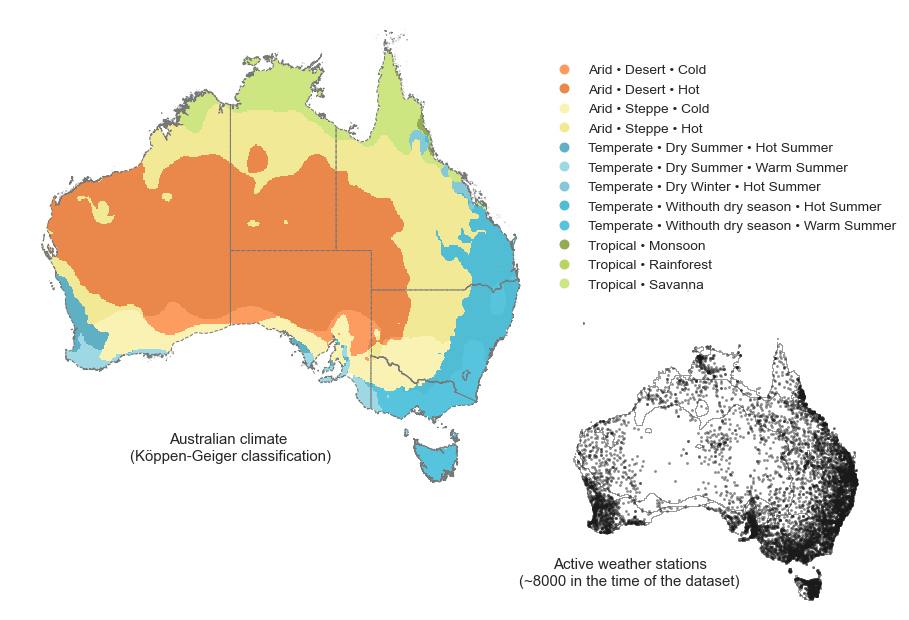

In [5]:
# Climate zones & weather stations density

# Build matplot legend
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html#sphx-glr-gallery-text-labels-and-annotations-custom-legends-py
# https://stackoverflow.com/questions/32012120/matplotlib-legend-vertical-rotation

# Color maps memo
# PuOr BuPu viridis inferno plasma magma tab20b OrRd

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(16,10))
ax.set_facecolor('white')
ax.grid(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(110, 186)

# Plot climate zones sorted to match color map
sorted = climate.sort_values('EN')
sorted.plot(ax=ax, column='EN', cmap=ListedColormap(sorted.Color.unique()),
            linewidth=0, legend=True, 
            legend_kwds={"facecolor":"white", "edgecolor":"w"})
ax.legend_.set_bbox_to_anchor((1.01,.91))

# Plot regions ?
ozshape.plot("STE_NAME21", ax=ax, linewidth=1, edgecolor='#777', facecolor='none', linestyle="dashed")
plt.title("Australian climate \n(Köppen-Geiger classification)", x=.25, y=.08, fontsize=15)

# Weather stations densities
ax = plt.axes([.5,0.,.5,.4])
ax.set_facecolor('white')
ax.grid(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(110, 160)

climate.plot("climate", ax=ax, facecolor="none", edgecolor="#999", legend=False)
sorted = stations[['Site name', 'geometry']].sjoin(climate[['EN', 'Color', 'geometry']])
sorted.plot(ax=ax, linewidth=0, markersize=8, color='k', alpha=.5, legend=False)
plt.title("Active weather stations\n(~8000 in the time of the dataset)", x=.22, y=.075, fontsize=15)

del(fig, ax, sorted)
plt.savefig("C:/Users/reyni/Fev23_BDS_meteo/data/geo/australian-climate & stations-density.png")

In [6]:
# Missing samples by year

tmp = df.groupby(df.Date.dt.to_period('M'), as_index=False).size()
tmp = tmp.assign(Month=tmp.Date.dt.strftime("%b"), Year=tmp.Date.dt.year)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Missing samples by year")
for y, ms in tmp.sort_values('Date').set_index('Month').groupby('Year').groups.items():
    diff = [m for m in months if m not in ms]
    print(f"{y}: {', '.join(diff) if diff else '_'}")
print(tmp)
del(tmp, months, y, ms, diff)

Missing samples by year
2007: Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct
2008: _
2009: _
2010: _
2011: Apr
2012: Dec
2013: Feb
2014: _
2015: _
2016: _
2017: Jul, Aug, Sep, Oct, Nov, Dec
        Date  size Month  Year
0    2007-11    30   Nov  2007
1    2007-12    31   Dec  2007
2    2008-01    31   Jan  2008
3    2008-02    27   Feb  2008
4    2008-03    28   Mar  2008
..       ...   ...   ...   ...
108  2017-02   277   Feb  2017
109  2017-03   286   Mar  2017
110  2017-04   288   Apr  2017
111  2017-05   313   May  2017
112  2017-06   244   Jun  2017

[113 rows x 4 columns]


In [7]:
# Samples counts by climate

fig = plt.figure(figsize=(14, 4))

tmp = climateMerged(df).groupby(['Climate', 'Color'], as_index=False).size().sort_values('Climate')
ax = sns.barplot(tmp, y='Climate', x='size', palette=tmp.Color, errorbar=None,
                 linewidth=0, width=.95)
ax.set_title(f"Sample counts by climate", x=-.3, y=1.05, fontsize=13)
ax.set_facecolor('white')
ax.grid(False)
plt.xlabel(None)
plt.ylabel(None)
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()

del(tmp, fig, ax, edges)
plt.savefig('outpout/sample-counts-by-climate.png')

C:\Users\reyni\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'Climate'

<Figure size 1008x288 with 0 Axes>

C:\Users\reyni\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'size'

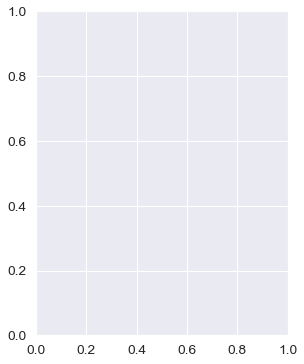

In [8]:
# Sample counts by climate and location

fig = plt.figure(figsize=(14, 9))

# By climate
ax = plt.axes([0.3,0.45,.25,.5])

tmp = climateMerged(df).groupby(['Climate', 'Color'], as_index=False).size().sort_values('Climate')
sns.barplot(tmp, x='Climate', y='size', palette=tmp.Color, errorbar=None,
            linewidth=0, width=.95)
ax.set_title(f"Sample counts by climates & locations", x=.34, y=1.05, fontsize=13)
ax.set_facecolor('white')
ax.grid(False)
plt.xlabel(None)
plt.ylabel("Sample counts", fontsize=11)
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=12)

# By location
ax = plt.axes([.7,0.0,.3,1.])
sns.countplot(df, y='Location', width=1, palette="icefire")
ax.set_facecolor('white')
ax.grid(False)
plt.xlabel("Sample counts", fontsize=11)
plt.ylabel(None)
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

del(fig, ax, tmp, edges)
plt.savefig("outpout/sample-counts-by-climate-location.png");

In [9]:
# Samples count's by location (keep it separated in case of)

fig = plt.figure(figsize=(14,4))

ax = sns.countplot(df, x='Location', palette="icefire")
ax.set_title(f"Sample counts by location",
            x=.14, y=1.01, fontsize=13)

ax.set_facecolor('white')
ax.grid(False)
ax.set_xlabel(None)
ax.set_ylabel("Sample counts")
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
plt.xticks(rotation=90)
plt.tight_layout()

del(fig, ax, edges)
plt.savefig("outpout/sample-counts-by-location.png");

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1008x288 with 0 Axes>

ValueError: Could not interpret input 'RainTomorrow'

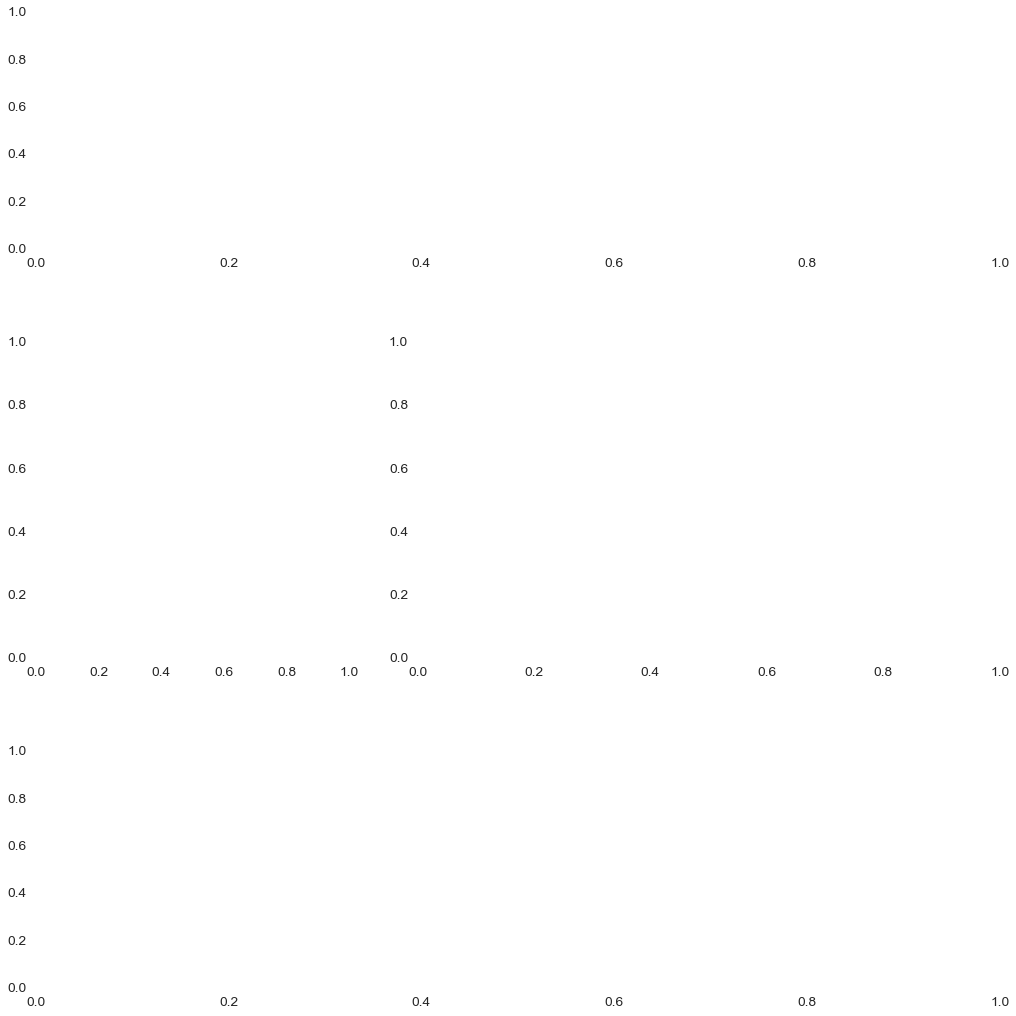

In [10]:
# RainTomorrow distribution Location/Global/Climate/Year
cmap = 'Set1'

# One Figure to rule them all
fig, axs = plt.subplot_mosaic(figsize=(14, 14), layout="constrained",
                              gridspec_kw={'width_ratios':[.7, 1.3],
                                'height_ratios':[.9, 1.2, .9], 'hspace': .2},
                              mosaic=[['head', 'head'],
                                      ['lmid', 'rmid'],
                                      ['foot', 'foot']])
for _, ax in axs.items():
    ax.set(facecolor='w')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

# By location
ax = axs.get('head')
ax = sns.countplot(df, ax=ax, x='Location', hue='RainTomorrow', palette=cmap)
ax.xaxis.set_tick_params(rotation=90) # plt.xticks(...)
ax.set_title("Target classes distribution                / by location", x=.15)
ax.legend_.set_visible(False)
ax.set_xlabel(None)
ax.set_ylabel(None)

# Globaly (pie)
ax = axs.get('lmid')
_, txs, atxs = ax.pie( df.groupby('RainTomorrow').size(), colors=plt.colormaps[cmap].colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"}, explode=[0,.1],
        autopct='%.1f%%', labeldistance=1.2, textprops={'fontsize':18},
        frame=False, labels=['No', 'Yes'])
plt.setp(atxs, weight="bold", color='w', fontsize=14)
ax.set_title("/ globaly", x=1.)

# By climate
ax = axs.get('rmid')
sns.countplot(climateMerged(df).sort_values('Climate'), ax=ax, y='Climate', hue='RainTomorrow',
              hue_order=['No', 'Yes'], palette=cmap)
ax.xaxis.set_tick_params(rotation=90) # plt.xticks(...)
ax.legend(facecolor='w', loc='upper right', bbox_to_anchor=[.7, 1.2])
ax.set_title("/ by climate", x=0.1)
ax.set_xlabel(None)
ax.set_ylabel(None)

# By Years
tmp = df.groupby([df.Date.dt.to_period('M'), 'RainTomorrow'], as_index=False).size()
tmp['Month'] = tmp.Date.dt.month
tmp['Year'] = tmp.Date.dt.year

ax = axs.get('foot')
ax = sns.lineplot(tmp, ax=ax, x='Year', y='size', hue='RainTomorrow', palette=cmap)
edges = ['bottom', 'left']
ax.spines[edges].set_visible(True)
ax.spines[edges].set_color("#888")
ax.spines[edges].set_color("#888")
ax.spines[edges].set_linewidth(.5)
ax.legend(facecolor='w')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title("/ by year")

del(fig, cmap, txs, atxs, tmp, axs, ax, edges)
plt.savefig("outpout/target-distribution.png")

In [11]:
df_f = df.drop(['Temp9am', 'MinTemp','MaxTemp', 'Pressure9am', 'Region', 'Group'], axis= 1)
df_f = df_f.dropna()
# print(df_f)
y = df_f['RainTomorrow']
df_f = df_f.drop(['RainTomorrow'], axis = 1)
# df_f = df_f.set_index('Location')

df_f = pd.get_dummies(df_f, columns=['WindGustDir','WindDir9am', 'WindDir3pm'])

df_f = pd.get_dummies(df_f, columns=['RainToday'])
y = y.replace ('No', 0)
y = y.replace ('Yes', 1)
df_f = climateMerged(df_f)
df_f = df_f.drop(['Color'], axis = 1)
df_f['Climate'] = df_f['Climate'].replace('Arid • Desert • Hot', 1)\
                                .replace('Arid • Steppe • Cold', 2)\
                                .replace('Arid • Steppe • Hot', 3)\
                                .replace('Temperate • Dry Summer • Hot Summer', 4)\
                                .replace('Temperate • Dry Summer • Warm Summer', 5)\
                                .replace('Temperate • Withouth dry season • Hot Summer', 6)\
                                .replace('Temperate • Withouth dry season • Warm Summer', 7)\
                                .replace('Tropical • Monsoon', 8)\
                                .replace('Tropical • Savanna', 9)

# df_f = pd.get_dummies(df_f, columns=['Climate'])
print(df_f)

            Date Location  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     2009-01-01    Cobar       0.0         12.0      12.3           48.0   
1     2009-01-02    Cobar       0.0         14.8      13.0           37.0   
2     2009-01-04    Cobar       0.0         10.8      10.6           46.0   
3     2009-01-05    Cobar       0.0         11.4      12.2           31.0   
4     2009-01-06    Cobar       0.0         11.2       8.4           35.0   
...          ...      ...       ...          ...       ...            ...   
56415 2017-06-20   Darwin       0.0          6.0      11.0           35.0   
56416 2017-06-21   Darwin       0.0          7.6       8.6           37.0   
56417 2017-06-22   Darwin       0.0          5.6      11.0           33.0   
56418 2017-06-23   Darwin       0.0          6.2      10.6           26.0   
56419 2017-06-24   Darwin       0.0          5.6      10.7           30.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
0      

In [12]:
import datetime

df_f['Month'] = df_f['Date'].dt.month 
df_f = df_f.drop('Date', axis =1)

df_f = df_f.set_index('Location')
pd.options.display.max_columns = False
print(df_f)
# df_f= climateMerged(df).groupby(['Climate', 'Color'], as_index=False).size().sort_values('Climate')
print(df_f)

          Rainfall  Evaporation  Sunshine  ...  RainToday_Yes  Climate  Month
Location                                   ...                               
Cobar          0.0         12.0      12.3  ...              0        3      1
Cobar          0.0         14.8      13.0  ...              0        3      1
Cobar          0.0         10.8      10.6  ...              0        3      1
Cobar          0.0         11.4      12.2  ...              0        3      1
Cobar          0.0         11.2       8.4  ...              0        3      1
...            ...          ...       ...  ...            ...      ...    ...
Darwin         0.0          6.0      11.0  ...              0        9      6
Darwin         0.0          7.6       8.6  ...              0        9      6
Darwin         0.0          5.6      11.0  ...              0        9      6
Darwin         0.0          6.2      10.6  ...              0        9      6
Darwin         0.0          5.6      10.7  ...              0   

In [21]:
#dendrogram 
from scipy.cluster.hierarchy import linkage, dendrogram


plt.figure(figsize = (20,10))

# Z = linkagedf_f, method = ('ward', metric = 'euclidean')
# dendrogram(Z, labels = df_f.index, leaf_rotation = 90, color_threshold = 250)
# plt.title("Dendrogramme CAH")

plt.show;

from sklearn.cluster import KMeans
print(df_f)

tab=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(df_f)
    tab.append(kmeans.inertia_)
plt.plot(range(1,10),tab)
plt.title("La méthode Elbow")
plt.xlabel("nombre de cluster")
plt.ylabel("Inertie intra-classe")
plt.show()

          Rainfall  Evaporation  Sunshine  ...  RainToday_Yes  Climate  Month
Location                                   ...                               
Cobar          0.0         12.0      12.3  ...              0        3      1
Cobar          0.0         14.8      13.0  ...              0        3      1
Cobar          0.0         10.8      10.6  ...              0        3      1
Cobar          0.0         11.4      12.2  ...              0        3      1
Cobar          0.0         11.2       8.4  ...              0        3      1
...            ...          ...       ...  ...            ...      ...    ...
Darwin         0.0          6.0      11.0  ...              0        9      6
Darwin         0.0          7.6       8.6  ...              0        9      6
Darwin         0.0          5.6      11.0  ...              0        9      6
Darwin         0.0          6.2      10.6  ...              0        9      6
Darwin         0.0          5.6      10.7  ...              0   

AttributeError: 'NoneType' object has no attribute 'split'

<Figure size 1440x720 with 0 Axes>

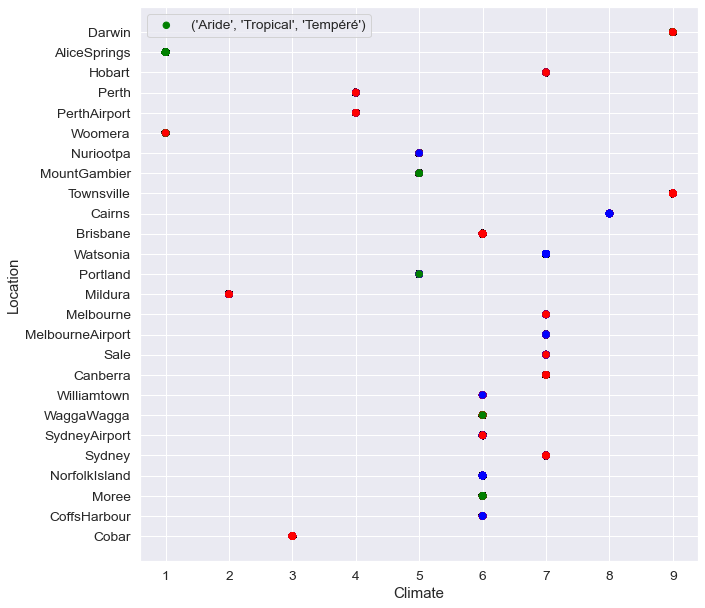

In [26]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(df_f)

#Visualisation
plt.figure(figsize =[10,10])
colormap=np.array(["red", "green", "blue"])
plt.scatter(df_f.Climate, df.Location, c=colormap[kmeans.labels_], s=42, )
plt.xlabel("Climate")
plt.ylabel("Location")
plt.legend()
plt.show()

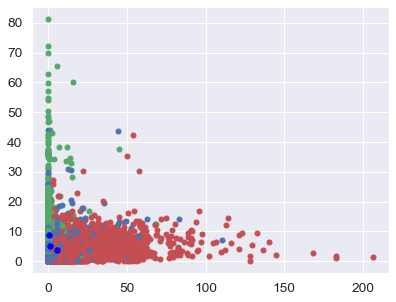

In [15]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

colors = ["g.","r.","b."]

# Graphique du nuage de points attribués au cluster correspondant
for i in range(len(df_f)):
    plt.plot(df_f.iloc[i,0], df_f.iloc[i,1], colors[labels[i]], markersize = 10)

# Graphique des centroïdes
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "o", color = "blue",s=30, linewidths = 1, zorder = 10)
plt.show()